In [344]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math

import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import MeanShift
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, RepeatedKFold
from sklearn import metrics
from sklearn import tree

from keras.models import Sequential
from keras.layers import Dense

In [7]:
warnings.filterwarnings('ignore')

In [8]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 100)

In [9]:
bio_df = pd.read_json('biospecimen_data.json')

clinical_df = pd.read_csv('clinical.tsv', sep='\t')

exposure_df = pd.read_csv('exposure.tsv', sep='\t')

family_history_df = pd.read_csv('family_history.tsv', sep='\t')

pathology_df = pd.read_csv('pathology_detail.tsv', sep='\t')

In [10]:
len(clinical_df)

107712

### The following function is used to clean the dataframes. Specifically, it drops numerous rows that do not have at least 8% of the data completed.

In [11]:
def df_cleaning(df):
    df = df.replace({"'--": np.nan, 'Not Reported': np.nan, 
                'not reported': np.nan, 'Unknown': np.nan, 'not allowed to collect': np.nan})
    
    col_len = len(df.columns)
    thresh_lvl = 0.08 * col_len
    df = df.dropna(thresh=thresh_lvl)
    
    if 'case_submitter_id' in df.columns:
        df['case_submitter_id'] = df['case_submitter_id'].str.replace('-', '')
        df['case_submitter_id'] = df['case_submitter_id'].str.replace('_', '')
    
    df['case_id'] = df['case_id'].str.replace('-', '')
    
    return(df)


In [12]:
bio_df = df_cleaning(bio_df)

clinical_df = df_cleaning(clinical_df)

exposure_df = df_cleaning(exposure_df)

family_history_df = df_cleaning(family_history_df)

pathology_df = df_cleaning(pathology_df)

In [13]:
print(len(clinical_df))
print(len(exposure_df))
print(len(family_history_df))
print(len(pathology_df))

40842
13287
1324
1011


In [14]:
'''print(len(clinical_df))
print(len(exposure_df))
print(len(family_history_df))
print(len(pathology_df))

33416
12214
1246
858'''

'print(len(clinical_df))\nprint(len(exposure_df))\nprint(len(family_history_df))\nprint(len(pathology_df))\n\n33416\n12214\n1246\n858'

### The biospecimen data can be used in analyzing a certain case_id and the "samples" will be pulled accordingly when needed for additional analysis.

In [15]:
# case_id / samples
bio_df['samples'][0][0]

{'distributor_reference': None,
 'sample_type_id': '85',
 'tumor_descriptor': 'Primary',
 'sample_id': '06c1a6af-3c39-4454-9667-d3b1b3f68eaa',
 'diagnosis_pathologically_confirmed': None,
 'sample_type': 'Next Generation Cancer Model',
 'tumor_code': None,
 'created_datetime': '2019-09-19T08:58:49.953315-05:00',
 'distance_normal_to_tumor': None,
 'time_between_excision_and_freezing': None,
 'growth_rate': None,
 'composition': '3D Organoid',
 'updated_datetime': '2023-02-22T07:39:25.979291-06:00',
 'days_to_collection': None,
 'method_of_sample_procurement': None,
 'state': 'released',
 'initial_weight': None,
 'preservation_method': 'Frozen',
 'portions': [{'portion_id': '9fe19075-7ffc-58bd-aa63-aa6612fc3560',
   'analytes': [{'amount': None,
     'experimental_protocol_type': 'mirVana (Allprep DNA) RNA',
     'aliquots': [{'no_matched_normal_targeted_sequencing': None,
       'amount': None,
       'selected_normal_wgs': None,
       'selected_normal_low_pass_wgs': None,
       'sub

### clinical_df can used the matching case_id to match biospecimen data when needed. Potentially combine the samples into the same dataframe.

In [16]:
clinical_df = clinical_df.drop_duplicates(subset=['case_submitter_id'])

In [17]:
clinical_df

,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_residence_at_enrollment,days_to_birth,days_to_death,ethnicity,gender,occupation_duration_years,premature_at_birth,race,vital_status,weeks_gestation_at_birth,year_of_birth,year_of_death,adrenal_hormone,age_at_diagnosis,ajcc_clinical_m,ajcc_clinical_n,ajcc_clinical_stage,ajcc_clinical_t,ajcc_pathologic_m,ajcc_pathologic_n,ajcc_pathologic_stage,ajcc_pathologic_t,ajcc_staging_system_edition,anaplasia_present,anaplasia_present_type,ann_arbor_b_symptoms,ann_arbor_b_symptoms_described,ann_arbor_clinical_stage,ann_arbor_extranodal_involvement,ann_arbor_pathologic_stage,best_overall_response,breslow_thickness,burkitt_lymphoma_clinical_variant,child_pugh_classification,circumferential_resection_margin,classification_of_tumor,cog_liver_stage,cog_neuroblastoma_risk_group,cog_renal_stage,cog_rhabdomyosarcoma_risk_group,days_to_best_overall_response,days_to_diagnosis,days_to_last_follow_up,days_to_last_known_disease_status,days_to_recurrence,eln_risk_classification,enneking_msts_grade,enneking_msts_metastasis,enneking_msts_stage,enneking_msts_tumor_site,esophageal_columnar_dysplasia_degree,esophageal_columnar_metaplasia_present,figo_stage,figo_staging_edition_year,first_symptom_prior_to_diagnosis,gastric_esophageal_junction_involvement,gleason_grade_group,gleason_grade_tertiary,gleason_patterns_percent,goblet_cells_columnar_mucosa_present,greatest_tumor_dimension,gross_tumor_weight,icd_10_code,igcccg_stage,inpc_grade,inpc_histologic_group,inrg_stage,inss_stage,international_prognostic_index,irs_group,irs_stage,ishak_fibrosis_score,iss_stage,largest_extrapelvic_peritoneal_focus,last_known_disease_status,laterality,lymph_node_involved_site,lymph_nodes_positive,lymph_nodes_tested,lymphatic_invasion_present,margin_distance,margins_involved_site,masaoka_stage,medulloblastoma_molecular_classification,metastasis_at_diagnosis,metastasis_at_diagnosis_site,method_of_diagnosis,micropapillary_features,mitosis_karyorrhexis_index,mitotic_count,morphology,non_nodal_regional_disease,non_nodal_tumor_deposits,ovarian_specimen_status,ovarian_surface_involvement,papillary_renal_cell_type,percent_tumor_invasion,perineural_invasion_present,peripancreatic_lymph_nodes_positive,peripancreatic_lymph_nodes_tested,peritoneal_fluid_cytological_status,pregnant_at_diagnosis,primary_diagnosis,primary_disease,primary_gleason_grade,prior_malignancy,prior_treatment,progression_or_recurrence,residual_disease,satellite_nodule_present,secondary_gleason_grade,site_of_resection_or_biopsy,sites_of_involvement,supratentorial_localization,synchronous_malignancy,tissue_or_organ_of_origin,transglottic_extension,tumor_confined_to_organ_of_origin,tumor_depth,tumor_focality,tumor_grade,tumor_largest_dimension_diameter,tumor_regression_grade,tumor_stage,vascular_invasion_present,vascular_invasion_type,weiss_assessment_score,who_cns_grade,who_nte_grade,wilms_tumor_histologic_subtype,year_of_diagnosis,chemo_concurrent_to_radiation,days_to_treatment_end,days_to_treatment_start,initial_disease_status,number_of_cycles,reason_treatment_ended,regimen_or_line_of_therapy,route_of_administration,therapeutic_agents,treatment_anatomic_site,treatment_arm,treatment_dose,treatment_dose_units,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type
8,0004d2513f704395b175c94c2f5b1b81,TCGADDAAVP,TCGA-LIHC,48,NaN,NaN,NaN,NaN,-17833,NaN,not hispanic or latino,male,NaN,NaN,asian,Alive,NaN,1959,NaN,NaN,17833,NaN,NaN,NaN,NaN,M0,N0,Stage I,T1,6th,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2752.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8170/3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Hepatocellular carcinoma, NOS",NaN,NaN,no,No,NaN,NaN,

In [18]:
len(clinical_df.columns)

158

In [19]:
clinical_df['tissue_or_organ_of_origin'].value_counts().head(10)

Bone marrow         4974
Kidney, NOS         1951
Breast, NOS         1103
Upper lobe, lung     752
Brain, NOS           740
Endometrium          627
Prostate gland       603
Ovary                593
Thyroid gland        521
Cervix uteri         518
Name: tissue_or_organ_of_origin, dtype: int64

In [20]:
clinical_df['treatment_type'].value_counts().head(10)

Pharmaceutical Therapy, NOS              5746
Radiation Therapy, NOS                   5723
Chemotherapy                              132
Stem Cell Transplantation, Autologous      69
Surgery, NOS                               25
Radiation, External Beam                   20
Targeted Molecular Therapy                 18
Immunotherapy (Including Vaccines)         18
Brachytherapy, Low Dose                    11
Surgery                                     6
Name: treatment_type, dtype: int64

In [21]:
clinical_df['tumor_grade'].value_counts().head(10)

G2            792
G3            460
G1            148
GX             32
G4             25
GB              6
High Grade      1
Name: tumor_grade, dtype: int64

In [22]:
clinical_df['primary_gleason_grade'].value_counts().head(10)

Pattern 4    250
Pattern 3    200
Pattern 5     49
Pattern 2      1
Name: primary_gleason_grade, dtype: int64

In [23]:
prim_diag = clinical_df['primary_diagnosis'].value_counts().head(10)

In [24]:
prim_diag

Acute myeloid leukemia, NOS                2123
Adenocarcinoma, NOS                        2024
Squamous cell carcinoma, NOS               1412
Precursor B-cell lymphoblastic leukemia    1284
Infiltrating duct carcinoma, NOS           1131
Multiple myeloma                            995
Neuroblastoma, NOS                          900
Glioblastoma                                735
Serous cystadenocarcinoma, NOS              714
Papillary adenocarcinoma, NOS               708
Name: primary_diagnosis, dtype: int64

In [25]:
clinical_df['vital_status'].value_counts().head(10)

Alive    13330
Dead      6431
Name: vital_status, dtype: int64

In [26]:
clinical_df['gender'].value_counts().head(10)

male       10213
female      9881
unknown        1
Name: gender, dtype: int64

In [27]:
test_race_values = clinical_df['race'].value_counts().head(10)

In [28]:
test_race_values

white                                        14599
black or african american                     2146
asian                                         1170
other                                          264
american indian or alaska native                53
native hawaiian or other pacific islander       42
unknown                                          3
Name: race, dtype: int64

In [29]:
clinical_df[clinical_df['vital_status'] == 'Dead']['gender'].value_counts()

male      3385
female    3046
Name: gender, dtype: int64

In [30]:
clinical_df[clinical_df['vital_status'] == 'Alive']['gender'].value_counts()

female     6740
male       6589
unknown       1
Name: gender, dtype: int64

### The following shows the death rate of each the most common fatal primary diagnoses

In [31]:
dead_prim_diag = clinical_df[clinical_df['vital_status'] == 'Dead']['primary_diagnosis'].value_counts().head(10)

In [32]:
dead_prim_diag

Acute myeloid leukemia, NOS                843
Glioblastoma                               593
Squamous cell carcinoma, NOS               550
Adenocarcinoma, NOS                        473
Serous cystadenocarcinoma, NOS             387
Neuroblastoma, NOS                         347
Infiltrating duct carcinoma, NOS           325
Precursor B-cell lymphoblastic leukemia    244
Malignant melanoma, NOS                    208
Multiple myeloma                           191
Name: primary_diagnosis, dtype: int64

In [33]:
dead_prim_diag.div(prim_diag).dropna()

Acute myeloid leukemia, NOS                0.397080
Adenocarcinoma, NOS                        0.233696
Glioblastoma                               0.806803
Infiltrating duct carcinoma, NOS           0.287356
Multiple myeloma                           0.191960
Neuroblastoma, NOS                         0.385556
Precursor B-cell lymphoblastic leukemia    0.190031
Serous cystadenocarcinoma, NOS             0.542017
Squamous cell carcinoma, NOS               0.389518
Name: primary_diagnosis, dtype: float64

### The following shows the survival rate of different primary diagnoses with the highest survival rate

In [34]:
alive_prim_diag = clinical_df[clinical_df['vital_status'] == 'Alive']['primary_diagnosis'].value_counts().head(10)

In [35]:
alive_prim_diag

Adenocarcinoma, NOS                        1496
Acute myeloid leukemia, NOS                1280
Precursor B-cell lymphoblastic leukemia     950
Squamous cell carcinoma, NOS                857
Multiple myeloma                            804
Infiltrating duct carcinoma, NOS            800
Papillary adenocarcinoma, NOS               612
Endometrioid adenocarcinoma, NOS            554
Neuroblastoma, NOS                          553
Wilms tumor                                 537
Name: primary_diagnosis, dtype: int64

In [36]:
alive_prim_diag.div(prim_diag).dropna()

Acute myeloid leukemia, NOS                0.602920
Adenocarcinoma, NOS                        0.739130
Infiltrating duct carcinoma, NOS           0.707339
Multiple myeloma                           0.808040
Neuroblastoma, NOS                         0.614444
Papillary adenocarcinoma, NOS              0.864407
Precursor B-cell lymphoblastic leukemia    0.739875
Squamous cell carcinoma, NOS               0.606941
Name: primary_diagnosis, dtype: float64

In [37]:
race_dead = clinical_df[clinical_df['vital_status'] == 'Dead']['race'].value_counts().head(10)

In [38]:
race_dead.div(test_race_values)

american indian or alaska native             0.396226
asian                                        0.240171
black or african american                    0.347158
native hawaiian or other pacific islander    0.333333
other                                        0.268939
unknown                                           NaN
white                                        0.333721
Name: race, dtype: float64

In [39]:
race_alive = clinical_df[clinical_df['vital_status'] == 'Alive']['race'].value_counts().head(10)

In [40]:
race_alive.div(test_race_values)

white                                        0.652031
black or african american                    0.639329
asian                                        0.737607
other                                        0.712121
american indian or alaska native             0.603774
native hawaiian or other pacific islander    0.642857
unknown                                      1.000000
Name: race, dtype: float64

In [41]:
exposure_df

,case_id,case_submitter_id,project_id,age_at_onset,alcohol_days_per_week,alcohol_drinks_per_day,alcohol_history,alcohol_intensity,alcohol_type,asbestos_exposure,bmi,cigarettes_per_day,coal_dust_exposure,environmental_tobacco_smoke_exposure,exposure_duration,exposure_duration_years,exposure_type,height,marijuana_use_per_week,pack_years_smoked,parent_with_radiation_exposure,radon_exposure,respirable_crystalline_silica_exposure,secondhand_smoke_as_child,smokeless_tobacco_quit_age,smoking_frequency,time_between_waking_and_first_smoke,tobacco_smoking_onset_year,tobacco_smoking_quit_year,tobacco_smoking_status,tobacco_use_per_day,type_of_smoke_exposure,type_of_tobacco_used,weight,years_smoked
0,0004d2513f704395b175c94c2f5b1b81,TCGADDAAVP,TCGA-LIHC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000d566c96c74f1cb36efa2222467983,TCGAKKA7B2,TCGA-PRAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000ead0dabf54606be041ea31b999840,C3N01179,CPTAC-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1962,2009,4,NaN,NaN,NaN,NaN,47.0
3,0011a67b1ba94a32a6b87850759a38cf,TCGADC6158,TCGA-READ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001887aa36d0463f8bcadec7043b4f2e,TCGADDA4NP,TCGA-LIHC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13282,ffef8d1df99d4cc09f4946488bfca131,C3L00586,CPTAC-3,NaN,NaN,NaN,Yes,Occasional Drinker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
13283,fff304a2113f499da88c9d3660c348d9,TCGARYA847,TCGA-LGG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13284,fff35c8088cd492380c10273ba5bed0f,TCGAAB2881,TCGA-LAML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13285,fffbef6c87dc46e3b977445af5847696,UTRISUBJECT001000367,TRIO-CRU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
len(exposure_df.columns)

35

In [43]:
exposure_df['age_at_onset'].value_counts()

Series([], Name: age_at_onset, dtype: int64)

In [44]:
print(clinical_df.columns)

print(exposure_df.columns)

print(family_history_df.columns)

print(pathology_df.columns)

Index(['case_id', 'case_submitter_id', 'project_id', 'age_at_index',
       'age_is_obfuscated', 'cause_of_death', 'cause_of_death_source',
       'country_of_residence_at_enrollment', 'days_to_birth', 'days_to_death',
       ...
       'treatment_arm', 'treatment_dose', 'treatment_dose_units',
       'treatment_effect', 'treatment_effect_indicator', 'treatment_frequency',
       'treatment_intent_type', 'treatment_or_therapy', 'treatment_outcome',
       'treatment_type'],
      dtype='object', length=158)
Index(['case_id', 'case_submitter_id', 'project_id', 'age_at_onset',
       'alcohol_days_per_week', 'alcohol_drinks_per_day', 'alcohol_history',
       'alcohol_intensity', 'alcohol_type', 'asbestos_exposure', 'bmi',
       'cigarettes_per_day', 'coal_dust_exposure',
       'environmental_tobacco_smoke_exposure', 'exposure_duration',
       'exposure_duration_years', 'exposure_type', 'height',
       'marijuana_use_per_week', 'pack_years_smoked',
       'parent_with_radiation_expos

In [45]:
print(clinical_df.shape)

print(exposure_df.shape)

print(family_history_df.shape)

print(pathology_df.shape)

(20095, 158)
(13287, 35)
(1324, 9)
(1011, 51)


# Beginning of combine_df

In [46]:
combined_df = clinical_df.merge(exposure_df, how='left', on='case_submitter_id')


In [47]:
combined_df.shape

(20095, 192)

In [48]:
combined_df = combined_df.merge(family_history_df, how='left', on='case_submitter_id')

In [49]:
combined_df.shape

(20393, 200)

In [50]:
combined_df = combined_df.merge(pathology_df, how='left', on='case_submitter_id')

In [51]:
combined_df.shape

(20408, 250)

In [52]:
duplicate_cols = combined_df.columns[combined_df.columns.duplicated()]

In [53]:
duplicate_cols

Index(['case_id_x', 'project_id_x', 'case_id_y', 'project_id_y'], dtype='object')

In [54]:
combined_df = combined_df.drop(columns=duplicate_cols)

In [55]:
combined_df['vital_status'].value_counts()

Alive    13581
Dead      6490
Name: vital_status, dtype: int64

In [469]:
clinical_df['vital_status'].unique()

array(['Alive', 'Dead', nan], dtype=object)

In [57]:
combined_df = combined_df.dropna(subset=['vital_status'])

In [465]:
combined_df.shape

(20071, 21)

In [467]:
combined_df['vital_status'].value_counts()

1    13581
0     6490
Name: vital_status, dtype: int64

In [483]:
vitality_dead = clinical_df[clinical_df['vital_status'] == 'Dead']

In [484]:
vitality_dead = vitality_dead[vitality_dead['year_of_birth'] > '1970']

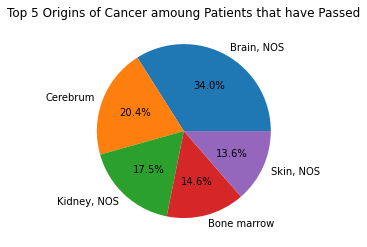

In [485]:
vital_pie = vitality_dead['tissue_or_organ_of_origin'].value_counts().sort_values(ascending=False).head(5)
vital_pie_values = vital_pie.values
vital_pie_labels = vital_pie.index

plt.pie(vital_pie_values, labels=vital_pie_labels, autopct='%1.1f%%')
plt.title('Top 5 Origins of Cancer amoung Patients that have Passed')
plt.show()

In [486]:
vitality_alive = clinical_df[clinical_df['vital_status'] == 'Alive']

In [489]:
vitality_alive = vitality_alive[vitality_alive['year_of_birth'] > '1970']

In [490]:
vitality_alive['treatment_type'].value_counts()

Radiation Therapy, NOS                     439
Pharmaceutical Therapy, NOS                420
Chemotherapy                                 3
Hormone Therapy                              2
Surgery, NOS                                 2
Radiation, Stereotactic/Gamma Knife/SRS      1
Radiation, 2D Conventional                   1
Name: treatment_type, dtype: int64

In [59]:
alcohol = combined_df[['age_at_diagnosis', 'gender', 'tissue_or_organ_of_origin', 'alcohol_history', 'alcohol_intensity']]
alcohol['age_at_diagnosis'] = round(pd.to_numeric(alcohol['age_at_diagnosis']) / 365, 0)

In [60]:
tabacco = combined_df[['age_at_diagnosis', 'gender', 'tissue_or_organ_of_origin', 'cigarettes_per_day', 'pack_years_smoked', 'years_smoked']]
tabacco['age_at_diagnosis'] = round(pd.to_numeric(tabacco['age_at_diagnosis']) / 365, 0)

In [61]:
alcohol = alcohol.dropna(subset=['alcohol_intensity'])

In [62]:
tabacco = tabacco.dropna(subset=['years_smoked'])

In [63]:
alcohol = alcohol[alcohol['alcohol_history'] == 'Yes']

In [64]:
alcohol['tissue_or_organ_of_origin'].value_counts().head(10)

Kidney, NOS            86
Upper lobe, lung       70
Head of pancreas       51
Lung, NOS              48
Lower lobe, lung       40
Corpus uteri           31
Larynx, NOS            25
Endometrium            16
Floor of mouth, NOS    15
Tongue, NOS            11
Name: tissue_or_organ_of_origin, dtype: int64

In [65]:
tabacco['tissue_or_organ_of_origin'].value_counts().head()

Upper lobe, lung    325
Lower lobe, lung    201
Kidney, NOS         125
Lung, NOS            68
Head of pancreas     58
Name: tissue_or_organ_of_origin, dtype: int64

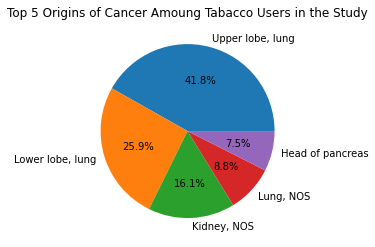

In [66]:
tab_pie = tabacco['tissue_or_organ_of_origin'].value_counts().sort_values(ascending=False).head(5)
tab_pie_values = tab_pie.values
tab_pie_labels = tab_pie.index

plt.pie(tab_pie_values, labels=tab_pie_labels, autopct='%1.1f%%')
plt.title('Top 5 Origins of Cancer Amoung Tabacco Users in the Study')
plt.show()

In [67]:
combined_df = combined_df.dropna(how='all', axis=1)

In [68]:
combined_df.shape

(20071, 123)

In [69]:
combined_df = combined_df.dropna(axis=1, thresh=100)

In [70]:
combined_df.shape

(20071, 84)

In [71]:
men_df = clinical_df[clinical_df['gender'] == 'male']

In [72]:
women_df = clinical_df[clinical_df['gender'] == 'female']

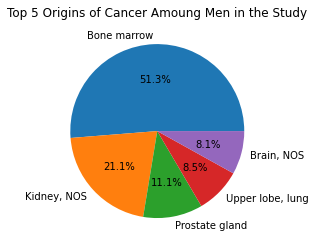

In [73]:
m_pie = men_df['tissue_or_organ_of_origin'].value_counts().sort_values(ascending=False).head(5)
m_pie_values = m_pie.values
m_pie_labels = m_pie.index

plt.pie(m_pie_values, labels=m_pie_labels, autopct='%1.1f%%')
plt.title('Top 5 Origins of Cancer Amoung Men in the Study')
plt.show()

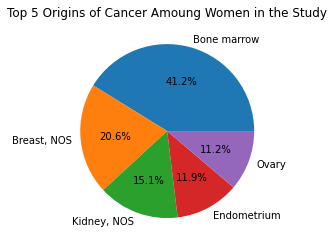

In [74]:
f_pie = women_df['tissue_or_organ_of_origin'].value_counts().sort_values(ascending=False).head(5)
f_pie_values = f_pie.values
f_pie_labels = f_pie.index

plt.pie(f_pie_values, labels=f_pie_labels, autopct='%1.1f%%')
plt.title('Top 5 Origins of Cancer Amoung Women in the Study')
plt.show()

In [462]:
combined_df['vital_status'].value_counts()

1    13581
0     6490
Name: vital_status, dtype: int64

In [ ]:
vitality = combined_df

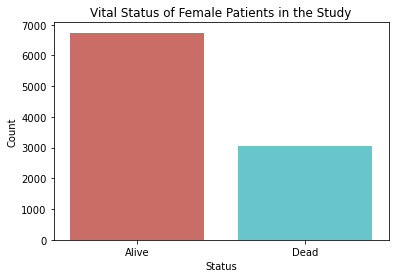

In [75]:
sns.countplot(x='vital_status', data=women_df, palette='hls')
plt.title('Vital Status of Female Patients in the Study')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

## Adjusting the vital_status variable to 1 for Alive and 0 for Dead

In [76]:
combined_df['vital_status'] = combined_df['vital_status'].replace({'Alive': 1, 'Dead': 0})

In [77]:
combined_df.columns

Index(['case_submitter_id', 'age_at_index', 'age_is_obfuscated',
       'cause_of_death', 'days_to_birth', 'days_to_death', 'ethnicity',
       'gender', 'race', 'vital_status', 'year_of_birth', 'year_of_death',
       'age_at_diagnosis', 'ajcc_clinical_m', 'ajcc_clinical_n',
       'ajcc_clinical_stage', 'ajcc_clinical_t', 'ajcc_pathologic_m',
       'ajcc_pathologic_n', 'ajcc_pathologic_stage', 'ajcc_pathologic_t',
       'ajcc_staging_system_edition', 'ann_arbor_b_symptoms',
       'ann_arbor_extranodal_involvement', 'ann_arbor_pathologic_stage',
       'best_overall_response', 'burkitt_lymphoma_clinical_variant',
       'classification_of_tumor', 'cog_renal_stage', 'days_to_diagnosis',
       'days_to_last_follow_up', 'days_to_last_known_disease_status',
       'eln_risk_classification', 'figo_stage', 'figo_staging_edition_year',
       'icd_10_code', 'inss_stage', 'iss_stage', 'last_known_disease_status',
       'masaoka_stage', 'metastasis_at_diagnosis', 'method_of_diagnosis',
  

In [78]:
combined_df = combined_df.dropna(axis=1, thresh=10000)

In [79]:
combined_df.columns

Index(['case_submitter_id', 'age_at_index', 'days_to_birth', 'ethnicity',
       'gender', 'race', 'vital_status', 'year_of_birth', 'age_at_diagnosis',
       'days_to_diagnosis', 'days_to_last_follow_up', 'icd_10_code',
       'morphology', 'primary_diagnosis', 'prior_malignancy',
       'prior_treatment', 'site_of_resection_or_biopsy',
       'tissue_or_organ_of_origin', 'year_of_diagnosis',
       'treatment_or_therapy', 'treatment_type'],
      dtype='object')

In [80]:
combined_df['morphology'] = combined_df['morphology'].str.replace('/', '').astype(float)

In [81]:
combined_df['treatment_type'].value_counts()

Pharmaceutical Therapy, NOS                5728
Radiation Therapy, NOS                     5703
Chemotherapy                                117
Stem Cell Transplantation, Autologous        96
Surgery, NOS                                 23
Radiation, External Beam                     20
Immunotherapy (Including Vaccines)           18
Targeted Molecular Therapy                   17
Brachytherapy, Low Dose                      11
Surgery                                       8
Hormone Therapy                               5
Brachytherapy, High Dose                      4
Radiation, 2D Conventional                    3
Stereotactic Radiosurgery                     1
Radiation, Stereotactic/Gamma Knife/SRS       1
Radiation, 3D Conformal                       1
Name: treatment_type, dtype: int64

# Logistic Regression

In [82]:
feature_cols = ['age_at_index', 'ethnicity',
       'gender', 'race', 'vital_status', 'year_of_birth', 'age_at_diagnosis',
       'morphology', 'primary_diagnosis', 'prior_malignancy',
       'prior_treatment', 'site_of_resection_or_biopsy',
       'tissue_or_organ_of_origin', 'year_of_diagnosis', 'treatment_type']

In [83]:
alg_model_df = combined_df[feature_cols]

In [84]:
alg_model_df[[
    'age_at_index', 'year_of_birth', 'age_at_diagnosis'
]] = alg_model_df[[
    'age_at_index', 'year_of_birth', 'age_at_diagnosis'
]].apply(pd.to_numeric)

In [85]:
alg_model_df['morphology'] = alg_model_df['morphology'].fillna(0)
alg_model_df['primary_diagnosis'] = alg_model_df['primary_diagnosis'].fillna('Other')
alg_model_df['prior_malignancy'] = alg_model_df['prior_malignancy'].fillna('unknown')
alg_model_df['prior_treatment'] = alg_model_df['prior_treatment'].fillna('unknown')
alg_model_df['site_of_resection_or_biopsy'] = alg_model_df['site_of_resection_or_biopsy'].fillna('unknown')
alg_model_df['year_of_diagnosis'] = alg_model_df['year_of_diagnosis'].fillna('unknown')
alg_model_df['treatment_type'] = alg_model_df['treatment_type'].fillna('unknown')
alg_model_df['tissue_or_organ_of_origin'] = alg_model_df['tissue_or_organ_of_origin'].fillna('unknown')
alg_model_df['age_at_index'] = alg_model_df['age_at_index'].fillna(alg_model_df['age_at_index'].mean())
alg_model_df['age_at_diagnosis'] = alg_model_df['age_at_diagnosis'].fillna(alg_model_df['age_at_diagnosis'].mean())
alg_model_df['year_of_birth'] = alg_model_df['year_of_birth'].fillna(alg_model_df['year_of_birth'].mean())
alg_model_df['race'] = alg_model_df['race'].fillna('unknown')
alg_model_df['ethnicity'] = alg_model_df['ethnicity'].fillna('unknown')

In [86]:
prim_diag_drop = alg_model_df['primary_diagnosis'].value_counts().loc[lambda x: x<3].index

alg_model_df.loc[alg_model_df['primary_diagnosis'].isin(prim_diag_drop), 'primary_diagnosis'] = 'Other'

In [87]:
categorical_features = ['morphology', 'primary_diagnosis', 'prior_malignancy', 
                        'prior_treatment', 'site_of_resection_or_biopsy', 
                        'year_of_diagnosis', 'treatment_type', 'tissue_or_organ_of_origin']

In [88]:
ohe_features = ['ethnicity', 'gender', 'race']

In [89]:
len(categorical_features), len(feature_cols), len(ohe_features), len(['age_at_index', 'year_of_birth', 'age_at_diagnosis', 
'days_to_last_follow_up'])

(8, 15, 3, 4)

## Adjusting some variables to numeric

In [90]:
lr_y = alg_model_df['vital_status']

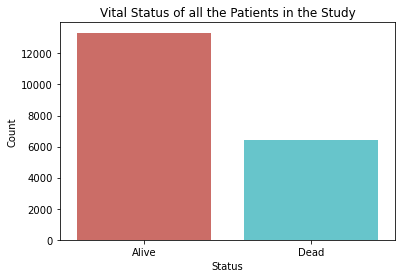

In [91]:
sns.countplot(x='vital_status', data=clinical_df, palette='hls')
plt.title('Vital Status of all the Patients in the Study')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

## Encoding

In [92]:
count_enc = ce.CountEncoder()

count_encoded = count_enc.fit_transform(alg_model_df[categorical_features])

In [93]:
count_encoded

,morphology,primary_diagnosis,prior_malignancy,prior_treatment,site_of_resection_or_biopsy,year_of_diagnosis,treatment_type,tissue_or_organ_of_origin
0,81703.0,360,9645,11485,393,1340,5728,385
1,89643.0,13,9444,8368,1921,348,8315,1945
2,81403.0,1970,9645,11485,498,1450,5728,500
3,89603.0,651,9444,8368,1921,348,8315,1945
4,83123.0,218,9444,8368,1921,398,8315,1945
...,...,...,...,...,...,...,...,...
20403,94503.0,112,9645,11485,438,1450,5703,438
20404,98613.0,2123,9645,11485,4355,1606,5703,5160
20405,98373.0,238,9444,8368,4355,1744,8315,5160
20406,89603.0,651,9444,8368,1921,228,8315,1945


In [94]:
test_frame = pd.get_dummies(alg_model_df, columns=ohe_features)

In [95]:
test_frame['age_at_diagnosis'] = test_frame['age_at_diagnosis'] / 365

In [96]:
test_frame

,age_at_index,vital_status,year_of_birth,age_at_diagnosis,morphology,primary_diagnosis,prior_malignancy,prior_treatment,site_of_resection_or_biopsy,tissue_or_organ_of_origin,year_of_diagnosis,treatment_type,ethnicity_hispanic or latino,ethnicity_not hispanic or latino,ethnicity_unknown,gender_female,gender_male,gender_unknown,race_american indian or alaska native,race_asian,race_black or african american,race_native hawaiian or other pacific islander,race_other,race_unknown,race_white
0,48.00000,1,1959.000000,48.857534,81703.0,"Hepatocellular carcinoma, NOS",no,No,Liver,Liver,2007,"Pharmaceutical Therapy, NOS",0,1,0,0,1,0,0,1,0,0,0,0,0
1,58.90579,1,1949.769126,1.383562,89643.0,Clear cell sarcoma of kidney,unknown,unknown,"Kidney, NOS","Kidney, NOS",2000,unknown,0,1,0,0,1,0,0,0,0,0,0,0,1
2,68.00000,1,1944.000000,68.068493,81403.0,"Adenocarcinoma, NOS",no,No,Prostate gland,Prostate gland,2012,"Pharmaceutical Therapy, NOS",0,0,1,0,1,0,0,0,0,0,0,0,1
3,58.90579,1,1949.769126,2.780822,89603.0,Wilms tumor,unknown,unknown,"Kidney, NOS","Kidney, NOS",2000,unknown,0,1,0,0,1,0,0,0,1,0,0,0,0
4,58.90579,1,1944.000000,72.556164,83123.0,"Renal cell carcinoma, NOS",unknown,unknown,"Kidney, NOS","Kidney, NOS",2016,unknown,0,0,1,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20403,45.00000,1,1967.000000,45.841096,94503.0,"Oligodendroglioma, NOS",no,No,Cerebrum,Cerebrum,2012,"Radiation Therapy, NOS",0,1,0,0,1,0,0,0,0,0,0,0,1
20404,48.00000,1,1961.000000,48.789041,98613.0,"Acute myeloid leukemia, NOS",no,No,Bone marrow,Bone marrow,2009,"Radiation Therapy, NOS",0,1,0,1,0,0,0,0,0,0,0,0,1
20405,58.90579,1,1949.769126,15.304110,98373.0,T lymphoblastic leukemia/lymphoma,unknown,unknown,Bone marrow,Bone marrow,2010,unknown,0,1,0,0,1,0,0,0,0,0,0,0,1
20406,58.90579,1,1949.769126,3.717808,89603.0,Wilms tumor,unknown,unknown,"Kidney, NOS","Kidney, NOS",1998,unknown,0,1,0,0,1,0,0,0,0,0,0,0,1


In [97]:
test_frame['age_at_diagnosis'].value_counts().head(30)

44.907945    310
90.060274     40
0.161644       9
90.057534      9
0.216438       9
65.043836      9
0.180822       9
0.175342       8
0.202740       8
66.687671      8
0.194521       8
68.046575      8
63.312329      8
0.147945       7
64.120548      7
63.895890      7
0.186301       7
1.860274       7
57.515068      7
60.684932      7
0.191781       7
70.043836      7
67.060274      6
0.860274       6
2.624658       6
60.764384      6
1.526027       6
3.095890       6
1.682192       6
52.704110      6
Name: age_at_diagnosis, dtype: int64

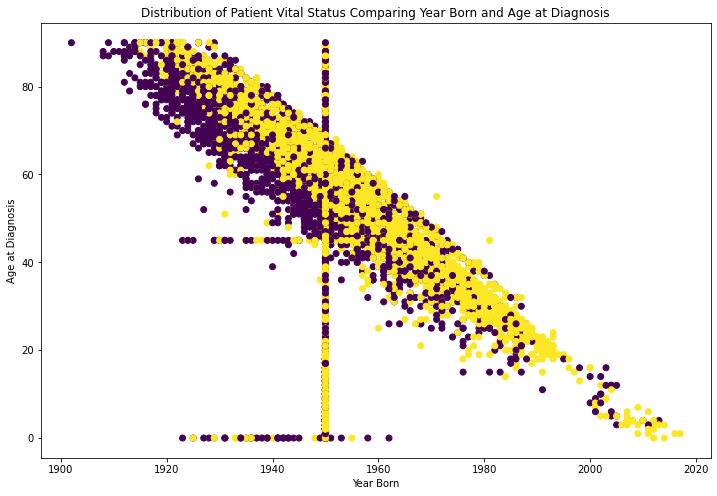

In [98]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(round(test_frame['year_of_birth'], 0), round(test_frame['age_at_diagnosis'], 0), c=test_frame['vital_status'])
plt.title('Distribution of Patient Vital Status Comparing Year Born and Age at Diagnosis')
plt.xlabel('Year Born')
plt.ylabel('Age at Diagnosis')
plt.show()

In [99]:
count_encoded

,morphology,primary_diagnosis,prior_malignancy,prior_treatment,site_of_resection_or_biopsy,year_of_diagnosis,treatment_type,tissue_or_organ_of_origin
0,81703.0,360,9645,11485,393,1340,5728,385
1,89643.0,13,9444,8368,1921,348,8315,1945
2,81403.0,1970,9645,11485,498,1450,5728,500
3,89603.0,651,9444,8368,1921,348,8315,1945
4,83123.0,218,9444,8368,1921,398,8315,1945
...,...,...,...,...,...,...,...,...
20403,94503.0,112,9645,11485,438,1450,5703,438
20404,98613.0,2123,9645,11485,4355,1606,5703,5160
20405,98373.0,238,9444,8368,4355,1744,8315,5160
20406,89603.0,651,9444,8368,1921,228,8315,1945


In [100]:
test_frame.shape

(20071, 25)

In [101]:
categorical_features

['morphology',
 'primary_diagnosis',
 'prior_malignancy',
 'prior_treatment',
 'site_of_resection_or_biopsy',
 'year_of_diagnosis',
 'treatment_type',
 'tissue_or_organ_of_origin']

In [102]:
ohe_features

['ethnicity', 'gender', 'race']

In [103]:
len(categorical_features)

8

In [104]:
test_frame = test_frame.drop(categorical_features, axis=1)

In [105]:
test_frame.shape

(20071, 17)

In [106]:
len(ohe_features)

3

In [107]:
test_frame = test_frame.join(count_encoded.add_suffix("_count"))

In [202]:
clinical_df['prior_malignancy'].value_counts()

no         9713
yes         989
unknown      66
Name: prior_malignancy, dtype: int64

In [109]:
test_frame.columns

Index(['age_at_index', 'vital_status', 'year_of_birth', 'age_at_diagnosis',
       'ethnicity_hispanic or latino', 'ethnicity_not hispanic or latino',
       'ethnicity_unknown', 'gender_female', 'gender_male', 'gender_unknown',
       'race_american indian or alaska native', 'race_asian',
       'race_black or african american',
       'race_native hawaiian or other pacific islander', 'race_other',
       'race_unknown', 'race_white', 'morphology_count',
       'primary_diagnosis_count', 'prior_malignancy_count',
       'prior_treatment_count', 'site_of_resection_or_biopsy_count',
       'year_of_diagnosis_count', 'treatment_type_count',
       'tissue_or_organ_of_origin_count'],
      dtype='object')

In [311]:
feature_cols = ['year_of_birth', 'age_at_diagnosis',
       'ethnicity_hispanic or latino', 'ethnicity_not hispanic or latino',
       'ethnicity_unknown', 'gender_female', 'gender_male', 'gender_unknown',
       'race_american indian or alaska native', 'race_asian',
       'race_black or african american',
       'race_native hawaiian or other pacific islander', 'race_other',
       'race_unknown', 'race_white', 'morphology_count',
       'primary_diagnosis_count',
       'year_of_diagnosis_count', 'treatment_type_count',
       'tissue_or_organ_of_origin_count']

# Logistic Regression

In [312]:
lr_X = test_frame[feature_cols]
lr_y = test_frame['vital_status']

In [313]:
lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(
    lr_X, lr_y, test_size=0.20, random_state=16)

In [314]:
lr_logr = LogisticRegression(random_state=16)
lr_logr.fit(lr_X_train, lr_y_train)

LogisticRegression(random_state=16)

In [315]:
lr_y_pred = lr_logr.predict(lr_X_test)

In [316]:
lr_conf_matrix = metrics.confusion_matrix(lr_y_test, lr_y_pred)
lr_conf_matrix

array([[ 222, 1114],
       [  93, 2586]], dtype=int64)

In [317]:
print(metrics.accuracy_score(lr_y_test, lr_y_pred))
print(metrics.f1_score(lr_y_test, lr_y_pred, average='weighted'))

0.6993773349937733
0.6304811365009819


In [318]:
lr_target_names = ['Alive', 'Dead']

print(metrics.classification_report(lr_y_test, lr_y_pred, target_names=lr_target_names))

              precision    recall  f1-score   support

       Alive       0.70      0.17      0.27      1336
        Dead       0.70      0.97      0.81      2679

    accuracy                           0.70      4015
   macro avg       0.70      0.57      0.54      4015
weighted avg       0.70      0.70      0.63      4015



In [319]:
clinical_df.groupby('vital_status')['treatment_type'].value_counts()

vital_status  treatment_type                         
Alive         Radiation Therapy, NOS                     3813
              Pharmaceutical Therapy, NOS                3808
              Stem Cell Transplantation, Autologous        62
              Chemotherapy                                 39
              Radiation, External Beam                     12
              Surgery, NOS                                 12
              Targeted Molecular Therapy                   10
              Brachytherapy, Low Dose                       8
              Immunotherapy (Including Vaccines)            7
              Hormone Therapy                               4
              Surgery                                       4
              Brachytherapy, High Dose                      3
              Radiation, 2D Conventional                    1
              Radiation, Stereotactic/Gamma Knife/SRS       1
              Stereotactic Radiosurgery                     1
Dead          Ph

In [320]:
clinical_df[clinical_df['tumor_focality'] == 'Multifocal']['vital_status'].value_counts()

Alive    74
Dead     21
Name: vital_status, dtype: int64

In [321]:
clinical_df

,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_residence_at_enrollment,days_to_birth,days_to_death,ethnicity,gender,occupation_duration_years,premature_at_birth,race,vital_status,weeks_gestation_at_birth,year_of_birth,year_of_death,adrenal_hormone,age_at_diagnosis,ajcc_clinical_m,ajcc_clinical_n,ajcc_clinical_stage,ajcc_clinical_t,ajcc_pathologic_m,ajcc_pathologic_n,ajcc_pathologic_stage,ajcc_pathologic_t,ajcc_staging_system_edition,anaplasia_present,anaplasia_present_type,ann_arbor_b_symptoms,ann_arbor_b_symptoms_described,ann_arbor_clinical_stage,ann_arbor_extranodal_involvement,ann_arbor_pathologic_stage,best_overall_response,breslow_thickness,burkitt_lymphoma_clinical_variant,child_pugh_classification,circumferential_resection_margin,classification_of_tumor,cog_liver_stage,cog_neuroblastoma_risk_group,cog_renal_stage,cog_rhabdomyosarcoma_risk_group,days_to_best_overall_response,days_to_diagnosis,days_to_last_follow_up,days_to_last_known_disease_status,days_to_recurrence,eln_risk_classification,enneking_msts_grade,enneking_msts_metastasis,enneking_msts_stage,enneking_msts_tumor_site,esophageal_columnar_dysplasia_degree,esophageal_columnar_metaplasia_present,figo_stage,figo_staging_edition_year,first_symptom_prior_to_diagnosis,gastric_esophageal_junction_involvement,gleason_grade_group,gleason_grade_tertiary,gleason_patterns_percent,goblet_cells_columnar_mucosa_present,greatest_tumor_dimension,gross_tumor_weight,icd_10_code,igcccg_stage,inpc_grade,inpc_histologic_group,inrg_stage,inss_stage,international_prognostic_index,irs_group,irs_stage,ishak_fibrosis_score,iss_stage,largest_extrapelvic_peritoneal_focus,last_known_disease_status,laterality,lymph_node_involved_site,lymph_nodes_positive,lymph_nodes_tested,lymphatic_invasion_present,margin_distance,margins_involved_site,masaoka_stage,medulloblastoma_molecular_classification,metastasis_at_diagnosis,metastasis_at_diagnosis_site,method_of_diagnosis,micropapillary_features,mitosis_karyorrhexis_index,mitotic_count,morphology,non_nodal_regional_disease,non_nodal_tumor_deposits,ovarian_specimen_status,ovarian_surface_involvement,papillary_renal_cell_type,percent_tumor_invasion,perineural_invasion_present,peripancreatic_lymph_nodes_positive,peripancreatic_lymph_nodes_tested,peritoneal_fluid_cytological_status,pregnant_at_diagnosis,primary_diagnosis,primary_disease,primary_gleason_grade,prior_malignancy,prior_treatment,progression_or_recurrence,residual_disease,satellite_nodule_present,secondary_gleason_grade,site_of_resection_or_biopsy,sites_of_involvement,supratentorial_localization,synchronous_malignancy,tissue_or_organ_of_origin,transglottic_extension,tumor_confined_to_organ_of_origin,tumor_depth,tumor_focality,tumor_grade,tumor_largest_dimension_diameter,tumor_regression_grade,tumor_stage,vascular_invasion_present,vascular_invasion_type,weiss_assessment_score,who_cns_grade,who_nte_grade,wilms_tumor_histologic_subtype,year_of_diagnosis,chemo_concurrent_to_radiation,days_to_treatment_end,days_to_treatment_start,initial_disease_status,number_of_cycles,reason_treatment_ended,regimen_or_line_of_therapy,route_of_administration,therapeutic_agents,treatment_anatomic_site,treatment_arm,treatment_dose,treatment_dose_units,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type
8,0004d2513f704395b175c94c2f5b1b81,TCGADDAAVP,TCGA-LIHC,48,NaN,NaN,NaN,NaN,-17833,NaN,not hispanic or latino,male,NaN,NaN,asian,Alive,NaN,1959,NaN,NaN,17833,NaN,NaN,NaN,NaN,M0,N0,Stage I,T1,6th,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2752.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8170/3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Hepatocellular carcinoma, NOS",NaN,NaN,no,No,NaN,NaN,

In [393]:
lr_mse = metrics.mean_squared_error(lr_y_test, lr_y_pred, squared=False)

In [394]:
lr_mse

0.5482906756513616

# Naive Bayes with vital status as Target

In [322]:
nb_vital = GaussianNB()

In [323]:
nb_vital.fit(lr_X_train, lr_y_train)

GaussianNB()

In [324]:
nb_vital_pred = nb_vital.predict(lr_X_test)

In [325]:
nb_accuracy = metrics.accuracy_score(lr_y_test, nb_vital_pred)
nb_f1_score = metrics.f1_score(lr_y_test, nb_vital_pred, average='weighted')

In [326]:
print('Naive Bayes Accuracy: ', nb_accuracy)
print('Naive Bayes F1 Score: ', nb_f1_score)

Naive Bayes Accuracy:  0.6931506849315069
Naive Bayes F1 Score:  0.6610456306093528


In [216]:
nb_cm = metrics.confusion_matrix(lr_y_test, nb_vital_pred, labels=[0,1])
nb_cm

array([[ 440,  896],
       [ 343, 2336]], dtype=int64)

In [124]:
nb_target_names = ['Alive', 'Dead']

print(metrics.classification_report(lr_y_test, nb_vital_pred, target_names=nb_target_names))

              precision    recall  f1-score   support

       Alive       1.00      1.00      1.00      1336
        Dead       1.00      1.00      1.00      2679

    accuracy                           1.00      4015
   macro avg       1.00      1.00      1.00      4015
weighted avg       1.00      1.00      1.00      4015



In [391]:
nb_mse = metrics.mean_squared_error(lr_y_test, nb_vital_pred, squared=False)

In [392]:
nb_mse

0.5539398117742514

# Random Forest for Primary Diagnosis

In [125]:
categorical_features_for_rf_pd = [
    'morphology', 'prior_malignancy', 'prior_treatment', 
    'site_of_resection_or_biopsy', 'year_of_diagnosis', 'treatment_type', 
    'tissue_or_organ_of_origin'
]

In [126]:
rf_df = pd.get_dummies(alg_model_df, columns=ohe_features)

In [127]:
rf_df

,age_at_index,vital_status,year_of_birth,age_at_diagnosis,morphology,primary_diagnosis,prior_malignancy,prior_treatment,site_of_resection_or_biopsy,tissue_or_organ_of_origin,year_of_diagnosis,treatment_type,ethnicity_hispanic or latino,ethnicity_not hispanic or latino,ethnicity_unknown,gender_female,gender_male,gender_unknown,race_american indian or alaska native,race_asian,race_black or african american,race_native hawaiian or other pacific islander,race_other,race_unknown,race_white
0,48.00000,1,1959.000000,17833.0,81703.0,"Hepatocellular carcinoma, NOS",no,No,Liver,Liver,2007,"Pharmaceutical Therapy, NOS",0,1,0,0,1,0,0,1,0,0,0,0,0
1,58.90579,1,1949.769126,505.0,89643.0,Clear cell sarcoma of kidney,unknown,unknown,"Kidney, NOS","Kidney, NOS",2000,unknown,0,1,0,0,1,0,0,0,0,0,0,0,1
2,68.00000,1,1944.000000,24845.0,81403.0,"Adenocarcinoma, NOS",no,No,Prostate gland,Prostate gland,2012,"Pharmaceutical Therapy, NOS",0,0,1,0,1,0,0,0,0,0,0,0,1
3,58.90579,1,1949.769126,1015.0,89603.0,Wilms tumor,unknown,unknown,"Kidney, NOS","Kidney, NOS",2000,unknown,0,1,0,0,1,0,0,0,1,0,0,0,0
4,58.90579,1,1944.000000,26483.0,83123.0,"Renal cell carcinoma, NOS",unknown,unknown,"Kidney, NOS","Kidney, NOS",2016,unknown,0,0,1,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20403,45.00000,1,1967.000000,16732.0,94503.0,"Oligodendroglioma, NOS",no,No,Cerebrum,Cerebrum,2012,"Radiation Therapy, NOS",0,1,0,0,1,0,0,0,0,0,0,0,1
20404,48.00000,1,1961.000000,17808.0,98613.0,"Acute myeloid leukemia, NOS",no,No,Bone marrow,Bone marrow,2009,"Radiation Therapy, NOS",0,1,0,1,0,0,0,0,0,0,0,0,1
20405,58.90579,1,1949.769126,5586.0,98373.0,T lymphoblastic leukemia/lymphoma,unknown,unknown,Bone marrow,Bone marrow,2010,unknown,0,1,0,0,1,0,0,0,0,0,0,0,1
20406,58.90579,1,1949.769126,1357.0,89603.0,Wilms tumor,unknown,unknown,"Kidney, NOS","Kidney, NOS",1998,unknown,0,1,0,0,1,0,0,0,0,0,0,0,1


In [128]:
len(rf_df['primary_diagnosis'].unique())

149

In [129]:
ohe_features

['ethnicity', 'gender', 'race']

In [130]:
rf_count_enc = ce.CountEncoder()

rf_count_encoded = rf_count_enc.fit_transform(rf_df[categorical_features_for_rf_pd])

In [131]:
rf_df = rf_df.drop(categorical_features_for_rf_pd, axis=1)

In [132]:
rf_df = rf_df.join(rf_count_encoded.add_suffix("_count"))

In [133]:
rf_df

,age_at_index,vital_status,year_of_birth,age_at_diagnosis,primary_diagnosis,ethnicity_hispanic or latino,ethnicity_not hispanic or latino,ethnicity_unknown,gender_female,gender_male,gender_unknown,race_american indian or alaska native,race_asian,race_black or african american,race_native hawaiian or other pacific islander,race_other,race_unknown,race_white,morphology_count,prior_malignancy_count,prior_treatment_count,site_of_resection_or_biopsy_count,year_of_diagnosis_count,treatment_type_count,tissue_or_organ_of_origin_count
0,48.00000,1,1959.000000,17833.0,"Hepatocellular carcinoma, NOS",0,1,0,0,1,0,0,1,0,0,0,0,0,81703.0,9645,11485,393,1340,5728,385
1,58.90579,1,1949.769126,505.0,Clear cell sarcoma of kidney,0,1,0,0,1,0,0,0,0,0,0,0,1,89643.0,9444,8368,1921,348,8315,1945
2,68.00000,1,1944.000000,24845.0,"Adenocarcinoma, NOS",0,0,1,0,1,0,0,0,0,0,0,0,1,81403.0,9645,11485,498,1450,5728,500
3,58.90579,1,1949.769126,1015.0,Wilms tumor,0,1,0,0,1,0,0,0,1,0,0,0,0,89603.0,9444,8368,1921,348,8315,1945
4,58.90579,1,1944.000000,26483.0,"Renal cell carcinoma, NOS",0,0,1,0,1,0,0,0,0,0,0,0,1,83123.0,9444,8368,1921,398,8315,1945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20403,45.00000,1,1967.000000,16732.0,"Oligodendroglioma, NOS",0,1,0,0,1,0,0,0,0,0,0,0,1,94503.0,9645,11485,438,1450,5703,438
20404,48.00000,1,1961.000000,17808.0,"Acute myeloid leukemia, NOS",0,1,0,1,0,0,0,0,0,0,0,0,1,98613.0,9645,11485,4355,1606,5703,5160
20405,58.90579,1,1949.769126,5586.0,T lymphoblastic leukemia/lymphoma,0,1,0,0,1,0,0,0,0,0,0,0,1,98373.0,9444,8368,4355,1744,8315,5160
20406,58.90579,1,1949.769126,1357.0,Wilms tumor,0,1,0,0,1,0,0,0,0,0,0,0,1,89603.0,9444,8368,1921,228,8315,1945


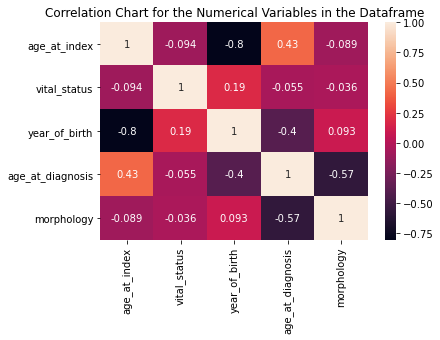

In [134]:
rf_dataplot = sns.heatmap(alg_model_df.corr(), annot=True)
plt.title('Correlation Chart for the Numerical Variables in the Dataframe')
plt.show()

In [366]:
rf_feature_cols = ['age_at_index', 'vital_status', 'year_of_birth', 
                   'age_at_diagnosis', 'ethnicity_hispanic or latino',
       'ethnicity_not hispanic or latino', 'ethnicity_unknown',
       'gender_female', 'gender_male', 'gender_unknown',
       'race_american indian or alaska native', 'race_asian',
       'race_black or african american',
       'race_native hawaiian or other pacific islander', 'race_other',
       'race_unknown', 'race_white', 'morphology_count',
       'prior_malignancy_count', 'prior_treatment_count',
       'site_of_resection_or_biopsy_count', 'year_of_diagnosis_count',
       'treatment_type_count', 'tissue_or_organ_of_origin_count']

In [367]:
rf_X = rf_df[rf_feature_cols]
rf_y = rf_df['primary_diagnosis']

In [368]:
rf_target = rf_count_enc.fit_transform(rf_y)

In [369]:
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(
    rf_X, rf_target, test_size=0.20, random_state=32)

In [370]:
rf_model = RandomForestClassifier()

In [371]:
rf_model.fit(rf_X_train, rf_y_train)

RandomForestClassifier()

In [372]:
rf_pred = rf_model.predict(rf_X_test)

In [373]:
rf_accuracy = metrics.accuracy_score(rf_y_test, rf_pred)
rf_f1_score = metrics.f1_score(rf_y_test, rf_pred, average='weighted')

In [374]:
print('Random Forest Accuracy: ', rf_accuracy)
print('Random Forest F1 Score: ', rf_f1_score)

Random Forest Accuracy:  0.9220423412204234
Random Forest F1 Score:  0.9144424439919


In [356]:
print('Random Forest Accuracy: ', rf_accuracy)
print('Random Forest F1 Score: ', rf_f1_score)

Random Forest Accuracy:  0.9202988792029888
Random Forest F1 Score:  0.9124189957878197


In [389]:
rf_mse = metrics.mean_squared_error(rf_y_test, rf_pred, squared=False)

In [390]:
rf_mse

224.39490407836522

# Additional Work

In [429]:
aw_df = pd.get_dummies(alg_model_df, columns=ohe_features)

In [430]:
aw_df['age_at_diagnosis'] = round(aw_df['age_at_diagnosis'] / 365, 0)

In [431]:
aw_df.shape

(20071, 25)

In [432]:
aw_df = aw_df[aw_df['age_at_diagnosis'] > 5]

In [433]:
aw_df.shape

(17144, 25)

In [434]:
aw_df.shape

(17144, 25)

In [436]:
aw_df

,age_at_index,vital_status,year_of_birth,age_at_diagnosis,morphology,primary_diagnosis,prior_malignancy,prior_treatment,site_of_resection_or_biopsy,tissue_or_organ_of_origin,year_of_diagnosis,treatment_type,ethnicity_hispanic or latino,ethnicity_not hispanic or latino,ethnicity_unknown,gender_female,gender_male,gender_unknown,race_american indian or alaska native,race_asian,race_black or african american,race_native hawaiian or other pacific islander,race_other,race_unknown,race_white
0,48.00000,1,1959.000000,49.0,81703.0,"Hepatocellular carcinoma, NOS",no,No,Liver,Liver,2007,"Pharmaceutical Therapy, NOS",0,1,0,0,1,0,0,1,0,0,0,0,0
2,68.00000,1,1944.000000,68.0,81403.0,"Adenocarcinoma, NOS",no,No,Prostate gland,Prostate gland,2012,"Pharmaceutical Therapy, NOS",0,0,1,0,1,0,0,0,0,0,0,0,1
4,58.90579,1,1944.000000,73.0,83123.0,"Renal cell carcinoma, NOS",unknown,unknown,"Kidney, NOS","Kidney, NOS",2016,unknown,0,0,1,0,1,0,0,0,0,0,0,0,1
5,70.00000,0,1940.000000,71.0,81403.0,"Adenocarcinoma, NOS",no,No,"Rectum, NOS","Rectum, NOS",2010,"Pharmaceutical Therapy, NOS",0,1,0,0,1,0,0,0,0,0,0,0,1
7,32.00000,1,1973.000000,32.0,81703.0,"Hepatocellular carcinoma, NOS",no,No,Liver,Liver,2005,"Radiation Therapy, NOS",0,1,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20401,58.90579,1,1965.000000,51.0,83803.0,"Endometrioid adenocarcinoma, NOS",unknown,unknown,Corpus uteri,Corpus uteri,2016,unknown,0,1,0,1,0,0,0,0,0,0,0,0,1
20403,45.00000,1,1967.000000,46.0,94503.0,"Oligodendroglioma, NOS",no,No,Cerebrum,Cerebrum,2012,"Radiation Therapy, NOS",0,1,0,0,1,0,0,0,0,0,0,0,1
20404,48.00000,1,1961.000000,49.0,98613.0,"Acute myeloid leukemia, NOS",no,No,Bone marrow,Bone marrow,2009,"Radiation Therapy, NOS",0,1,0,1,0,0,0,0,0,0,0,0,1
20405,58.90579,1,1949.769126,15.0,98373.0,T lymphoblastic leukemia/lymphoma,unknown,unknown,Bone marrow,Bone marrow,2010,unknown,0,1,0,0,1,0,0,0,0,0,0,0,1


In [437]:
categorical_features_for_aw = [
    'primary_diagnosis', 'morphology', 'prior_malignancy', 'prior_treatment', 
    'site_of_resection_or_biopsy', 'year_of_diagnosis', 'treatment_type', 
    'tissue_or_organ_of_origin'
]

In [438]:
aw_count_enc = ce.CountEncoder()

aw_count_encoded = aw_count_enc.fit_transform(aw_df[categorical_features_for_aw])

aw_df = aw_df.drop(categorical_features_for_aw, axis=1)

aw_df = aw_df.join(aw_count_encoded.add_suffix("_count"))

In [439]:
aw_df['age_at_diagnosis'].value_counts().head()

45.0    467
61.0    460
63.0    441
64.0    432
60.0    422
Name: age_at_diagnosis, dtype: int64

In [440]:
aw_feature_cols = ['vital_status', 'year_of_birth',
       'ethnicity_hispanic or latino', 'ethnicity_not hispanic or latino',
       'ethnicity_unknown', 'gender_female', 'gender_male', 'gender_unknown',
       'race_american indian or alaska native', 'race_asian',
       'race_black or african american',
       'race_native hawaiian or other pacific islander', 'race_other',
       'race_unknown', 'race_white', 'primary_diagnosis_count',
       'morphology_count', 'prior_malignancy_count', 'prior_treatment_count',
       'site_of_resection_or_biopsy_count',
       'treatment_type_count', 'tissue_or_organ_of_origin_count']

In [441]:
aw_X = aw_df[aw_feature_cols]
aw_y = aw_df['age_at_diagnosis']



aw_X_train, aw_X_test, aw_y_train, aw_y_test = train_test_split(
    aw_X, aw_y, test_size=0.20, random_state=64)

In [442]:
aw_cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [443]:
aw_lasso = Lasso(alpha=1.0)

aw_scores = cross_val_score(aw_lasso, aw_X_train, aw_y_train, scoring='neg_mean_absolute_error', cv=aw_cv, n_jobs=-1)

aw_scores = np.absolute(aw_scores)

In [444]:
print(np.mean(aw_scores), np.std(aw_scores))

10.506298523559666 0.24410817951469094


In [445]:
aw_lasso.fit(aw_X_train, aw_y_train)

aw_pred = aw_lasso.predict(aw_X_test)

In [446]:
aw_mse = metrics.mean_squared_error(aw_y_test, aw_pred, squared=False)

In [447]:
aw_mse

15.060515710625218

In [448]:
aw_X_train.shape

(13715, 22)

# More Work

In [451]:
aw_X_train.shape

(13715, 22)

In [455]:
model = Sequential()

model.add(Dense(5, input_dim=22, activation='relu'))

model.add(Dense(5, activation='relu'))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(aw_X_train, aw_y_train, batch_size=20, epochs=15, verbose=0)

In [456]:
mw_pred = model.predict(aw_X_test)

mw_mse = metrics.mean_squared_error(aw_y_test, mw_pred, squared=False)

108/108 [==============================] - 0s 1ms/step


In [457]:
mw_mse

25.602840446330664

# Decision Tree

In [458]:
dt_model = DecisionTreeClassifier()

dt_model.fit(aw_X_train, aw_y_train)

dt_y_pred = dt_model.predict(aw_X_test)

In [459]:
print("Accuracy:",metrics.accuracy_score(aw_y_test, dt_y_pred))

Accuracy: 0.13094196558763488


In [460]:
mw_mse = metrics.mean_squared_error(aw_y_test, dt_y_pred, squared=False)

In [461]:
mw_mse

7.550220699043029

# Research age of diagnosis for 'vital_status' == 'Dead'

# Analysis of ?years after diagnosis for 'vital_status' == 'Dead' patients, discussing the 'primary_diagnosis' for ?years after minimized sorted.